# init

In [17]:
import os
import sys

    
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from PIL import Image, ImageDraw

import radii as radi
import numpy as np
import SimpleITK as sitk
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import Interface as I
from getting_started import getting_started_dir

%matplotlib inline

In [18]:
def draw_line_from_point_to_point(draw, p1, p2):
    draw.line((p1[0], p1[1], p2[0], p2[1]),fill=(255,101,80,40), width=2)

def drawLine(image, rays):
    
    im = Image.open(image).convert("RGBA")
    draw = ImageDraw.Draw(im) 
 
    #draw.line((backCounterPoint[0], backCounterPoint[1], frontCounterPoint[0], frontCounterPoint[1]), fill=200, width=5)
    for rayIndex, ray in enumerate(rays):
        p1 = np.array(ray[0])
        p2 = np.array(ray[-1])
        v = p2-p1
        center = v/2.0
        p11 = p1+0.45*v
        p12 = p1+0.55*v
        
        draw.text((0,0),"lines next to the numbers are showing front rays",fill=(255,255,255,128))
        draw.text((ray[-1][0], ray[-1][1]),str(rayIndex),fill=(255,255,255,128))
        #draw.line((ray[0][0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
        draw_line_from_point_to_point(draw, p1, p11)
        draw_line_from_point_to_point(draw, p12, p2)
        #draw.line((center[0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
        #draw.line((ray[0][0], ray[0][1], ray[-1][0], ray[-1][1]),fill=(255,101,80,1), width=2)
    im.show()

    #im.save(sys.stdout, "PNG")
    

In [19]:
def plotCircularProfiles(raysProfileList):
    

 #   t1 = np.arange(0.0, 5.0, 0.1)
    length = len(raysProfileList)
    #plt.figure(1)
    plt.figure(figsize=(10,18))
    
    for rayIndex, ray in enumerate(raysProfileList[0:length]):
        l = len(ray)*0.092
        x = np.arange(-l/2.0, l/2.0, 0.092)
        plt.subplot(len(raysProfileList),1, rayIndex+1)
        
        #plt.subplot(len(raysProfileList),1, rayIndex+1, frameon=False)
        #plt.axis('off')  
        plt.plot(x,ray,label=str(rayIndex))
        assert(len(ray) % 2 == 1)
        id_mid_point = int((len(ray)-1)/2)
        plt.plot(0, ray[id_mid_point], "o")
        plt.legend()
        plt.tight_layout()
    plt.show() 


In [22]:
def statistics(pos):
    rays, raysProfiles = radiusCalculator.getProfileAtThisPoint(inputImage_s13, pos)
    
    selectedBackProfile, selectedFrontProfile, radiusList,\
    minRadius, BackCountorPoint, frontCounterPoint,\
    counterList,raysProfiles_1 = radiusCalculator.getRadiusFromProfile(inputImage_s13, pos)
    
    drawLine(inputTifImage_s13, rays)
    plotCircularProfiles(raysProfiles)

In [23]:
def collectRadii(points, cutOffValues, numberOfRays): 
    radiiSet = []
    for cutOff in cutOffValues:
       
        radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                                 zResolution=0.5,
                                                 xySize=20,
                                                 numberOfRays=numberOfRays,
                                                 tresholdPercentage=cutOff)
        radii = radiusCalculator.getProfileOfThesePoints(inputImage_s13, points)
         
        radiiSet.append(radii)
        del radiusCalculator
    return radiiSet


In [103]:
def scatterPlot(radiiData, style = 'scatter'):

    g1 = radiiData[0]
    g2 = radiiData[1]
    g3 = radiiData[2]
    
    gLen = len(g1)
    area = 30
    
    data = (g1, g2, g3)
    colors = ("red", "green", "blue")
    groups = ("0.25", "0.5", "0.75")
     
   
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
 
    for data, color, group in zip(data, colors, groups):
        x = np.arange(0, gLen, 1)
        y = data
        if style == 'scatter':
            ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=area, label=group)
        elif style == 'line':
            ax.plot(x, y, c=color, label=group)


    plt.title('radius scatter plot')
    plt.legend(loc=2)
    plt.show()

# optional: switches on clicking mode

In [77]:

imgArray = sitk.GetArrayViewFromImage(inputImage_s13)

f,imgplot=plt.subplots()
imgplot = plt.imshow(imgArray);

pos = []
def onclick(event):
    pos = []
    pos.append([event.xdata,event.ydata])
    statistics(pos[0])

f.canvas.mpl_connect('button_press_event', onclick)
f.show()

# load data

In [8]:
mdb = I.ModelDataBase('/nas1/Data_anajafgholi/results/20190410_profiling')

In [9]:
inputTifImage_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/tif/max_z_projections','S13_max_z_projection.tif')
inputAmData_s13 = I.os.path.join(getting_started_dir, 'radii/data/neuron1/am','S13_final_done_Alison_zScale_40.am')

In [10]:
imageFileReader = sitk.ImageFileReader()
imageFileReader.SetFileName(inputTifImage_s13)
inputImage_s13 = imageFileReader.Execute()

# compute

In [91]:
points = radi.spacialGraph.getSpatialGraphPoints(inputAmData_s13)
points = mdb.maybe_calculate('points', lambda: map(lambda x: map(lambda y: int(y/0.092), x), points))
radiiSet = mdb.maybe_calculate('radiiSet', lambda: collectRadii(points, [0.25, 0.5, 0.75], 10))

In [92]:
intensity_at_point = [inputImage_s13.GetPixel(point) for point in points]


# analysis

In [28]:
radiusCalculator = radi.calcRad.RadiusCalculator(xyResolution=0.092,
                                         zResolution=0.5,
                                         xySize=20,
                                         numberOfRays=10,
                                         tresholdPercentage=0.5)

In [29]:
[points[idx] for idx, p in enumerate(radiiSet[1]) if p == 100]

[[435, 495, 35],
 [1819, 537, 71],
 [1301, 407, 135],
 [1309, 407, 142],
 [1419, 420, 121],
 [2547, 529, 192],
 [2740, 568, 227],
 [2743, 565, 235],
 [3146, 276, 320],
 [4045, 87, 313],
 [4039, 89, 313],
 [1309, 407, 142],
 [4187, 56, 277]]

## dark point on axon, sligthly beside structure

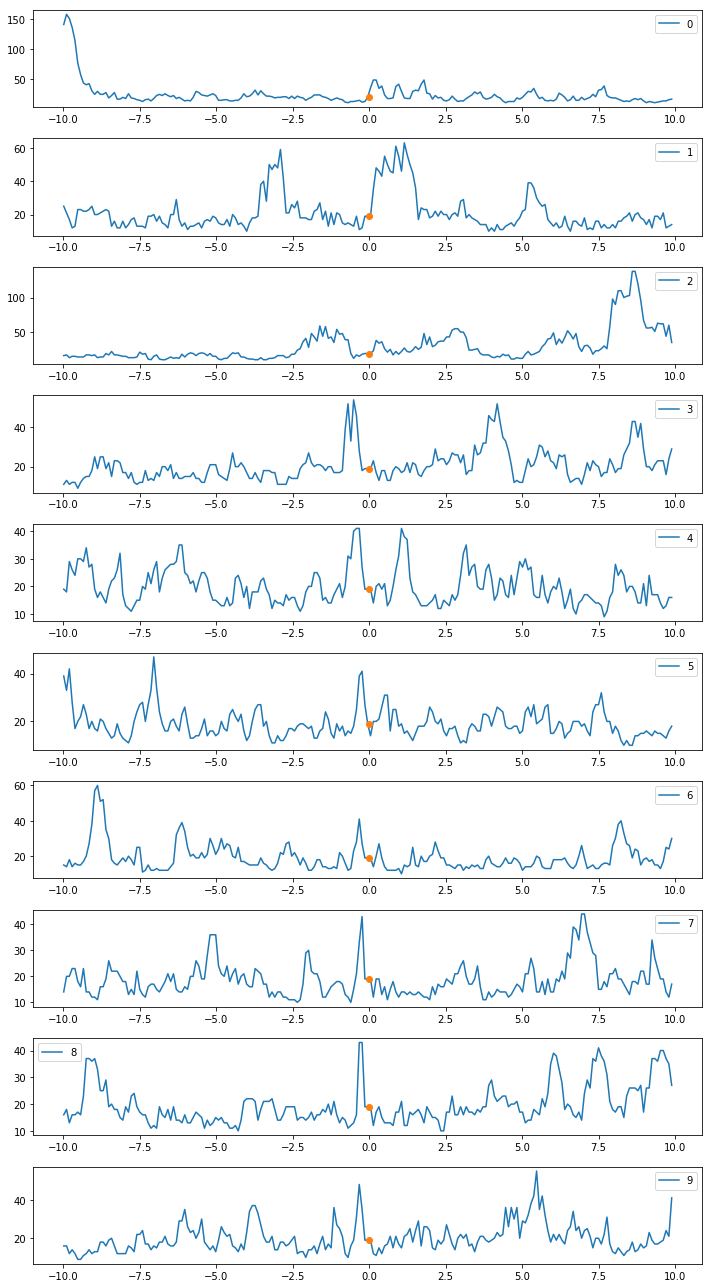

In [30]:
statistics([2740, 568, 227])

## bla

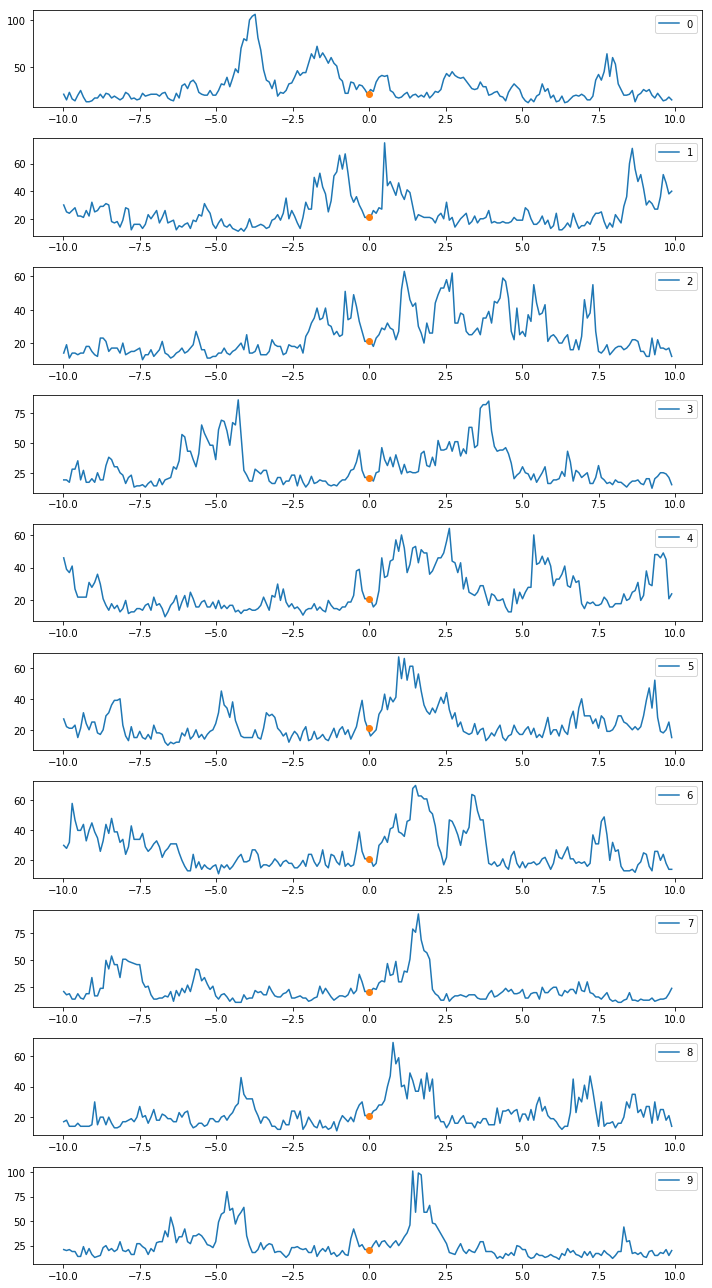

In [32]:
statistics([1309, 407, 142])

# intensity distribution structure vs. background

In [57]:
def get_random_point(image, n):
    dim = image.GetSize()
    intensities = []
    for n in range(n):
        point = [I.np.random.randint(0, dim[0]), I.np.random.randint(0, dim[1])]
        intensities.append(image.GetPixel(point))
    return intensities

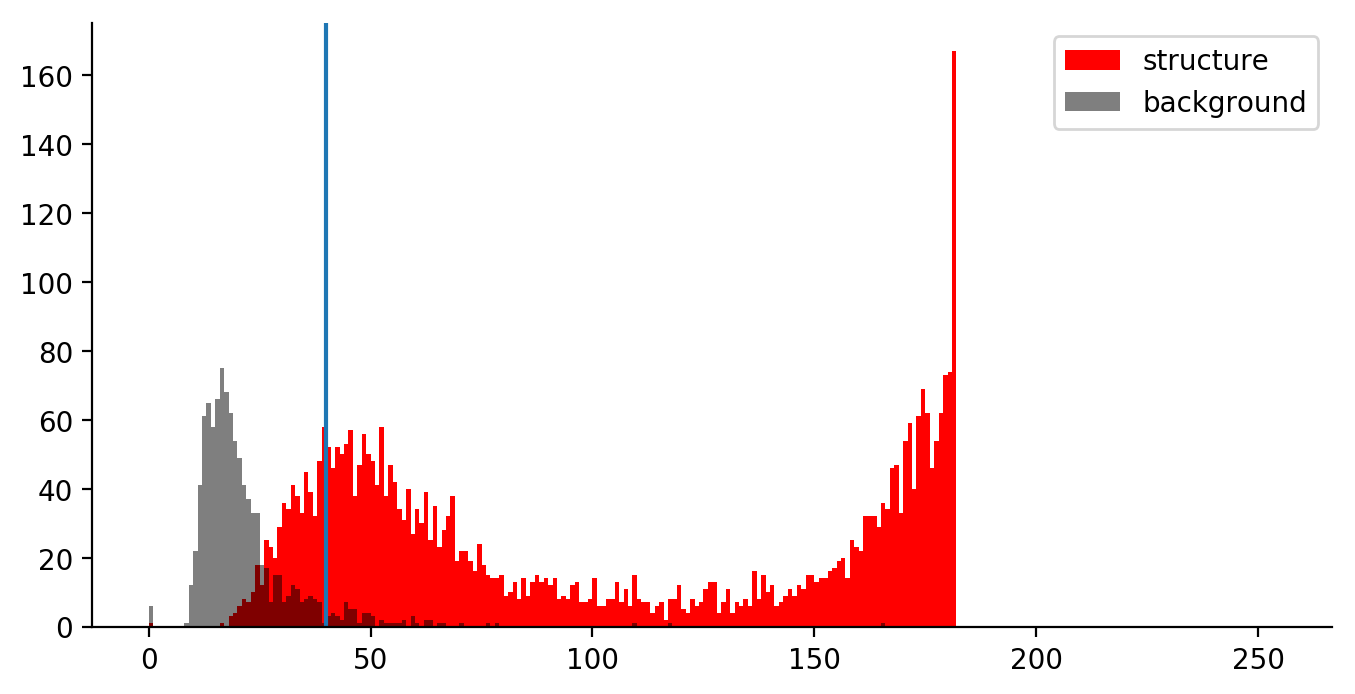

In [185]:
I.plt.figure(figsize = (8,4), dpi = 200)
bins = I.np.arange(0,255)
_ = I.plt.hist(intensity_at_point, bins = bins, label = 'structure', color = 'r')
_ = I.plt.hist(get_random_point(inputImage_s13, 1000), bins = bins, label = 'background', color = 'k', alpha = .5)
I.plt.legend()
I.plt.axvline(40)
I.sns.despine()


# scatterplot

## of all structure

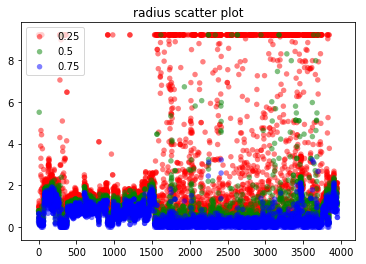

In [116]:
scatterPlot(map(lambda x: I.np.array(x)*0.092, radiiSet))

## scatterplot of bright (>100) structure

In [189]:
pdf = I.pd.DataFrame(radiiSet).T*0.092

In [190]:
pdf['intensity'] = intensity_at_point

In [210]:
selected_pdf = pdf[pdf.intensity > 40]

In [211]:
radiiSet_selected = map(lambda columnname: list(selected_pdf[columnname]), [0,1,2])

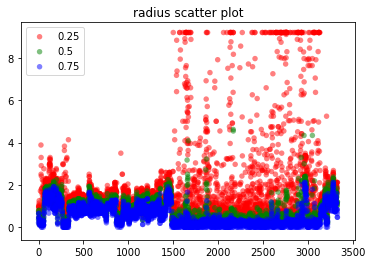

In [212]:
scatterPlot(radiiSet_selected)

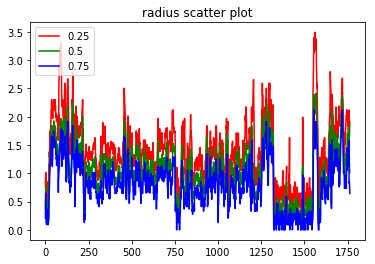

In [128]:
scatterPlot(radiiSet_selected, style = 'line') 

(array([  87.,  682.,  555.,  135.,   65.,   31.,   27.,   15.,    8.,    5.]),
 array([ 0.15122121,  0.34789692,  0.54457262,  0.74124832,  0.93792402,
         1.13459973,  1.33127543,  1.52795113,  1.72462684,  1.92130254,
         2.11797824]),
 <a list of 10 Patch objects>)

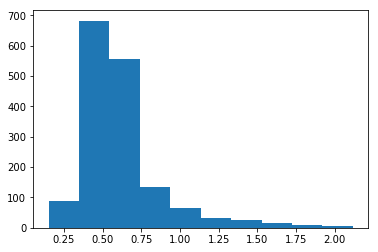

In [129]:
pdf_selected = pdf[pdf.intensity > 120]
I.plt.hist(pdf_selected[0]-pdf_selected[2])

In [168]:
bins = I.np.arange(0,10,.1)
out = []
for intensity_cutoff in range(0,200,1):
    pdf_selected = pdf[pdf.intensity > intensity_cutoff]
    out.append(I.np.histogram(pdf_selected[0]-pdf_selected[2], bins = bins, normed = True)[0])

In [171]:
error_pdf = I.pd.DataFrame(out, index = range(0,200,1), columns = bins[:-1])
error_pdf.index.name = 'intensity_cutoff'
error_pdf = error_pdf.T
error_pdf.index.name = 'error / micron'
error_pdf = error_pdf.iloc[::-1]


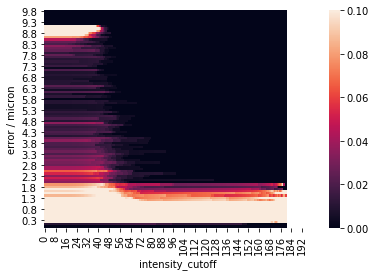

In [172]:
I.sns.heatmap(error_pdf, vmax=.1)

In [177]:
bins = I.np.arange(0,10,.1)
out = {}
for intensity_cutoff in range(0,200,1):
    pdf_selected = pdf[pdf.intensity > intensity_cutoff]
    out[intensity_cutoff] = len(pdf_selected) / float(len(pdf))

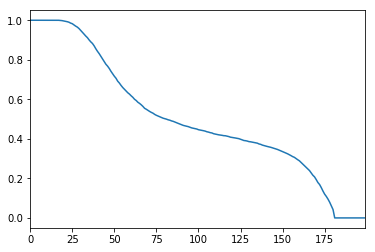

In [179]:
I.pd.Series(out).plot()

In [184]:
out[40]

0.8424380374304502

In [67]:
def variancePlot(radiiSet, points):
    for i, point in enumerate(points):
        ave = (radiiSet[0][i]+radiiSet[1][i]+radiiSet[2][i])/3.0
        for 
    
    

ERROR! Session/line number was not unique in database. History logging moved to new session 639


In [ ]:
def histogram(radii, points)